# Generating The Observations

This notebook draws observations from the assumed BBH mass and redshift distribution, which follows
$$
\frac{\mathrm{d} N}{\mathrm{d} V \mathrm{d} t} = R_0 \left( 1 + z \right)^{\gamma},
$$
(all quantities in the source-frame).  $R_0$ is the $z = 0$ merger rate, and $\gamma$ gives the slope of the merger rate at small $z$.  We use $R_0 = 100 \, \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}$ and $\gamma = 3$ (see `true_params.py`).  The mass distribution is  
$$
p\left( m_1, m_2 \right) \propto m_1^{-\alpha} m_2^{\beta} f_\mathrm{smooth}\left( m_1 \right) f_\mathrm{smooth} \left( m_2 \right) H\left( m_1 - m_2 \right),
$$
where 
$$
f_\mathrm{smooth} \left( m \right) = \begin{cases} 
1 & M_{0} \leq m < M_{1} \\ 
\exp\left[ - \frac{\left( \log m - \log M \right)^2}{2 \sigma_M^2} \right]& m < M_0, \quad m > M_1
\end{cases}
$$
True parameters are as given in `true_params.py`.

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import multiprocessing as multi
from scipy.integrate import cumtrapz
from scipy.interpolate import RectBivariateSpline, interp1d
import seaborn as sns

from tqdm import tqdm, tqdm_notebook
from true_params import true_params, uncert, ifo

# p = '/Users/wfarr/Research/CBCPopulation/O2Populations/code'
# try:
#     sys.path.index(p)
# except ValueError:
#     sys.path.append(p)
    
# import vt
    
sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

We need to implement some detectability criterion to determine how many mergers we are going to observe.  Here we choose to do that in an approximate way.  We assume that the SNR of our signal in the detector is given by 
$$
\rho_\mathrm{obs} = \rho_\mathrm{opt}\left( m_1\left(1+z\right), m_2\left(1+z\right), d_L\left(z\right) \right) \Theta + N(0,1),
$$
where $\Theta$ is a parameter meant to encapsulate the effect of the angular variables (sky position, orientation) in multiple detectors.  We assume that $\Theta$ is drawn from the distribution in [Finn & Chernoff (1993)](https://ui.adsabs.harvard.edu/#abs/1993PhRvD..47.2198F/abstract).  This distribution applies only to a single detector; we incorporate the effects of multiple detectors on distance measurements (but not on detectability!) by assuming we measure $\Theta$ with uncertainty (a perfect measurement of $\Theta$ would yield a relative error on the distance $\sigma_d/d \sim 1/\rho_\mathrm{opt}$).

Written this way, we can first compute a table of optimal SNR versus detector-frame masses and distances and then interpolate to find the optimal SNR of any signal; this is independent of cosmology.  The cell below takes about 10 minutes to run on my laptop, but results are saved to `optimal_snr.h5`

In [ ]:
nosnr = 250
mmin_osnr = 1
mmax_osnr = 250
ms = exp(linspace(log(mmin_osnr), log(mmax_osnr), nosnr))
z_gpc = cosmo.z_at_value(Planck15.luminosity_distance, 1*u.Gpc)

osnrs = zeros((nosnr, nosnr))
with tqdm_notebook(total=(nosnr+1)*nosnr/2) as prog:
    for i, m1 in enumerate(ms):
        for j in range(i+1):
            m2 = ms[j]
            osnrs[i,j] = vt.optimal_snr(m1/(1+z_gpc), m2/(1+z_gpc), z_gpc, psd_fn=vt.ls.SimNoisePSDaLIGODesignSensitivityP1200087)
            osnrs[j,i] = osnrs[i,j]
            prog.update(1)
    
with h5py.File('optimal_snr.h5', 'w') as out:
    out.create_dataset('ms', data=ms, compression='gzip', shuffle=True)
    out.create_dataset('SNR', data=osnrs, compression='gzip', shuffle=True)
    out.attrs['D_L'] = '1 Gpc'

Since that takes a long time to run, here is code that loads the optimal SNR matrix:

In [3]:
with h5py.File('optimal_snr.h5', 'r') as inp:
    ms = array(inp['ms'])
    osnrs = array(inp['SNR'])

osnr_interp = RectBivariateSpline(ms, ms, osnrs)

def optimal_snr(m1obs, m2obs, dl):
    return osnr_interp.ev(m1obs, m2obs)/dl

In [4]:
zMax = 3 # upper mass limit would be SNR 5 at z = 3
z = expm1(linspace(log(1), log(zMax+1), 1000))
dNdz = 4.0*pi*true_params['R0']*(1+z)**(true_params['gamma']-1)*Planck15.differential_comoving_volume(z).to(u.Gpc**3/u.sr).value

Nperyear = trapz(dNdz, z)
Nz = cumtrapz(dNdz, z, initial=0)

z_icdf = interp1d(Nz/Nperyear, z)

We will need to draw $\Theta$:

In [5]:
with h5py.File('thetas.h5', 'r') as f:
    ts = array(f['Theta'])
ts = concatenate((ts, [0.0, 1.0]))
ts = sort(ts)

In [6]:
theta_icdf = interp1d(linspace(0, 1, ts.shape[0]), ts)

In [7]:
def smooth_pl(x, a, x0, x1, s0, s1):
    xa = x**a
    sl = where(x < x0, exp(-0.5*square((log(x)-log(x0))/s0)), 1.0)
    sh = where(x > x1, exp(-0.5*square((log(x)-log(x1))/s1)), 1.0)
    
    return xa*sl*sh

In [8]:
m0 = true_params['MMin']
m1 = true_params['MMax']
s0 = true_params['sigma_min']
s1 = true_params['sigma_max']

mmin = exp(log(m0) - 5*s0) # 5-sigma
mmax = exp(log(m1) + 5*s1)

ms = exp(linspace(log(mmin), log(mmax), 1000))
pm1s = smooth_pl(ms, -true_params['alpha'], m0, m1, s0, s1)
pm2s = smooth_pl(ms, true_params['beta'], m0, m1, s0, s1)

cm1s_disc = cumtrapz(pm1s, ms, initial=0)
cm1s_disc /= cm1s_disc[-1]

cm2s_disc = cumtrapz(pm2s, ms, initial=0)
cm2s_disc /= cm2s_disc[-1]

icdfm1 = interp1d(cm1s_disc, ms)
icdfm2 = interp1d(cm2s_disc, ms)
cdfm2 = interp1d(ms, cm2s_disc)

In [9]:
def draw_truth():
    m1 = icdfm1(rand())
    m2 = icdfm2(rand())
    while m2 >= m1:
        m1 = icdfm1(rand())
        m2 = icdfm2(rand())
        
    z = z_icdf(rand())
    t = theta_icdf(rand())
    
    return (m1, m2, z, t)

In [10]:
def observe(m1, m2, z, t):
    m1obs = m1*(1+z)
    m2obs = m2*(1+z)
    dl = Planck15.luminosity_distance(z).to(u.Gpc).value
    rho = optimal_snr(m1obs, m2obs, dl)*t
    
    rho_obs = rho + randn()
    
    mt = m1obs+m2obs
    eta = m1obs*m2obs/(mt*mt)
    mc = mt*eta**(3.0/5.0)
    
    smc = abs(uncert['threshold_snr']/rho_obs*uncert['mc'])    
    mcobs = random.lognormal(mean=log(mc), sigma=smc)
    
    seta = uncert['threshold_snr']/rho_obs*uncert['eta']
    etaobs = 1
    while (etaobs < 0) or (etaobs > 0.25):
        etaobs = eta + seta*randn()
        
    st = uncert['threshold_snr']/rho_obs*uncert['Theta']
    tobs = 2
    while (tobs < 0) or (tobs > 1):
        tobs = t + st*randn()
        
    return ((mcobs, etaobs, rho_obs, tobs), (smc, seta, 1.0, st))

In [11]:
old_state = random.get_state()
random.seed(256838694)

try:
    m1s = []
    m2s = []
    zs = []
    thetas = []

    mcobs = []
    etaobs = []
    rhoobs = []
    tobs = []
    
    sigma_mc = []
    sigma_eta = []
    sigma_rho = []
    sigma_t = []

    Nsmall_tot = random.poisson(Nperyear/12.0) # One month
    N1yr_tot = Nsmall_tot + random.poisson(Nperyear*(1-1/12.0)) # One year
    N5yr_tot = N1yr_tot + random.poisson(Nperyear*4) # Five years

    for i, _ in enumerate(tqdm(range(N5yr_tot))):
        if rand() < ifo['duty_cycle']:
            m1, m2, z, t = draw_truth()

            (mc, et, rh, to), (smc, seta, srh, st) = observe(m1, m2, z, t)

            if rh > 8:
                m1s.append(m1)
                m2s.append(m2)
                zs.append(z)
                thetas.append(t)

                mcobs.append(mc)
                etaobs.append(et)
                rhoobs.append(rh)
                tobs.append(to)
                
                sigma_mc.append(smc)
                sigma_eta.append(seta)
                sigma_rho.append(srh)
                sigma_t.append(st)

        if i == Nsmall_tot-1:
            Nsmall = len(m1s)
        elif i == N1yr_tot-1:
            N1yr = len(m1s)
        elif i == N5yr_tot-1:
            N5yr = len(m1s)

    with h5py.File('observations.h5', 'w') as out:
        out.attrs['small'] = (Nsmall, ifo['duty_cycle']/12)
        out.attrs['1yr'] = (N1yr, ifo['duty_cycle'])
        out.attrs['5yr'] = (N5yr, ifo['duty_cycle']*5)
        out.attrs['Tobs'] = ifo['duty_cycle']*5

        def cd(n, d):
            d = array(d)
            out.create_dataset(n, data=d, compression='gzip', shuffle=True)
        cd('m1s', m1s)
        cd('m2s', m2s)
        cd('zs', zs)
        cd('thetas', thetas)

        cd('mcobs', mcobs)
        cd('etaobs', etaobs)
        cd('rhoobs', rhoobs)
        cd('thetaobs', tobs)
        
        cd('sigma_mc', sigma_mc)
        cd('sigma_eta', sigma_eta)
        cd('sigma_rho', sigma_rho)
        cd('sigma_t', sigma_t)
finally:
    random.set_state(old_state)

100%|██████████| 2995558/2995558 [08:29<00:00, 5883.80it/s]


In [12]:
print('Number observed in one month = {:d}'.format(Nsmall))
print('Number observed in 1 year = {:d}'.format(N1yr))
print('Number observed in 5 year = {:d}'.format(N5yr))

Number observed in one month = 109
Number observed in 1 year = 1043
Number observed in 5 year = 5011


Here is the true mass distribution ($m_1$):

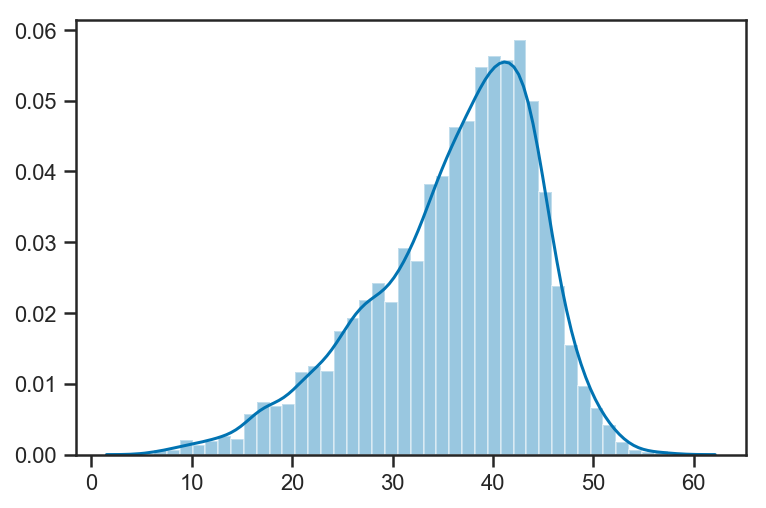

In [13]:
sns.distplot(m1s)

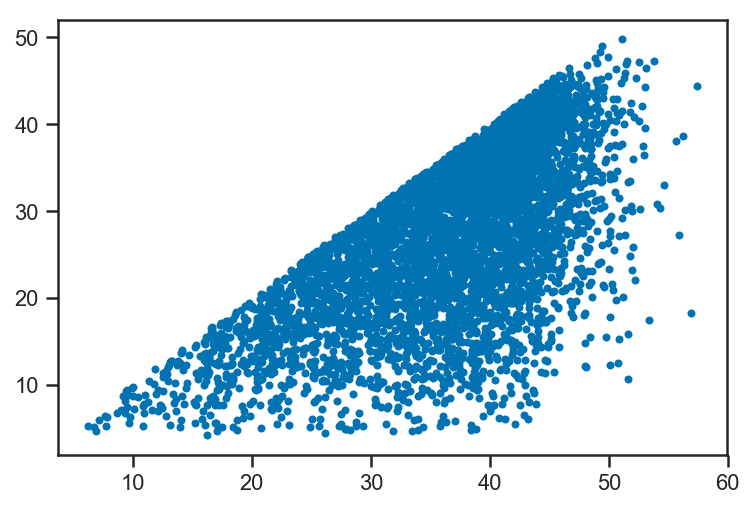

In [14]:
plot(m1s, m2s, '.')

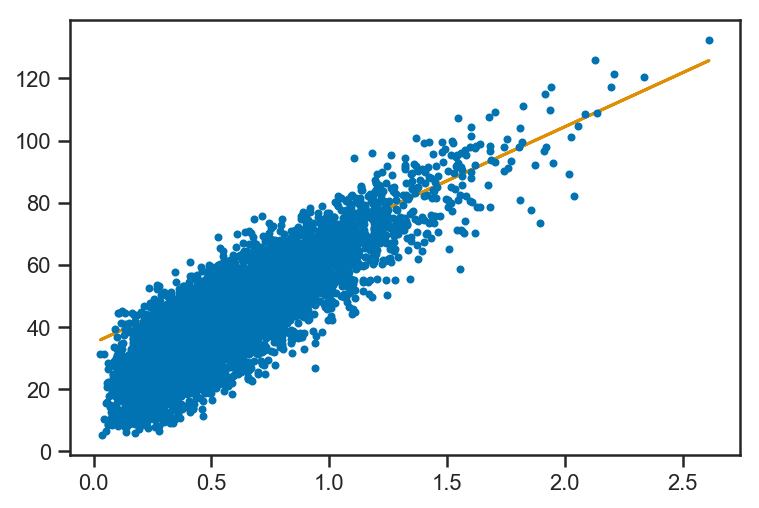

In [16]:
errorbar(zs, mcobs, yerr=sigma_mc, fmt='.')
plot(zs, 80*0.25**(3.0/5.0)*(1+array(zs)))

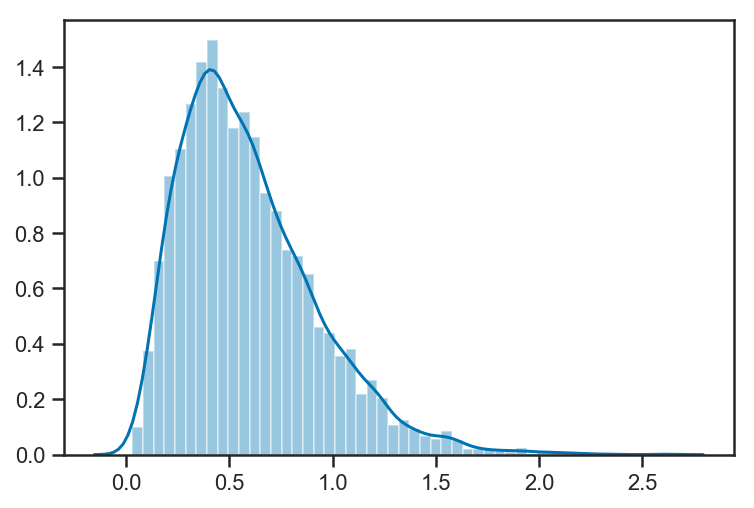

In [17]:
sns.distplot(zs)